In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 13.7 MB/s 
     |████████████████████████████████| 9.8 MB 76.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rc('font',family='Malgun Gothic') # 한글폰트 설정
mpl.rcParams['axes.unicode_minus'] = False # 마이너스 단위 설정

In [ ]:
def get_date(year=None,startdate = None, enddate=None):
    import datetime
    import numpy as np
    import pandas as pd 
    if startdate == None:
        date = str(year) + '0101'
        date = datetime.datetime.strptime(date,'%Y%m%d')
    else:
        date = startdate
        date = datetime.datetime.strptime(date,'%Y%m%d')
    if enddate != None:
        enddate = datetime.datetime.strptime(enddate,'%Y%m%d')

    li = []
    stop = 0
    stop_year = date.year + 1
    while stop == 0:
        li.append(date)
        date = date + datetime.timedelta(days=1)
        if date.year == stop_year:
            stop = 1
        elif date - datetime.timedelta(days=1) == enddate:
            stop = 1
    df = pd.DataFrame(np.array(li),columns=['SOLDDATE'])
    df.SOLDDATE = df.SOLDDATE.apply(lambda x: str(x.date()))
    return df

In [ ]:
import pandas as pd
import mariadb
import sys

# Connect to MariaDB Platform
try:
    conn = mariadb.connect(
        user="root",
        password="root",
        host="34.64.158.237",
        port=3306,
        database="smart_factory"
    )
except mariadb.Error as e:
    print(f"Error connecting to MariaDB Platform: {e}")
    sys.exit(1)

cur = conn.cursor()
cur.execute(f"show columns from `rawdata`;")
col = cur.fetchall()
col_new = [i[0] for i in col]
cur.execute(f"SELECT * FROM `rawdata`")
x = cur.fetchall()
df = pd.DataFrame(x, columns=col_new)
df

,SOLDDATE,CUSTID,PRODNAME,PRODCODE,REGION_U,TEMP_M,HUM_M,CONSTRUCTION,CONSTRUCTION_RATE,QUANT
0,2019-01-01,2001102,PEMA-HR1000,PEMA043101200,경상북도,-1.94669,-0.487412,-0.797754,-0.561657,6900.000000
1,2019-01-01,2006400,CSA5000,PEMA033035303,서울,-1.96775,-0.998611,-0.797754,-0.561657,8200.000000
2,2019-01-01,2001200,PEMA-HR1500,PEMA013128400,충청북도,-1.72562,-0.259528,-0.797754,-0.561657,7300.000000
3,2019-01-01,2006200,PEMA-HR1000,PEMA013064802,충청남도,-1.63088,-0.013167,-0.797754,-0.561657,8100.000000
4,2019-01-01,2005700,CSA5000,PEMA033035309,경기도남부,-1.90459,-0.056280,-0.797754,-0.561657,8700.000000
...,...,...,...,...,...,...,...,...,...,...
31369,2021-12-31,2002100,PEMA-HR1000,PEMA013106100,경기도남부,-2.01939,-2.206630,1.743650,0.956978,9400.000000
31370,2021-12-31,2002300,PEMA-HR1000,PEMA023008000,경상북도,-1.84553,-2.240330,1.743650,0.956978,9400.000000
31371,2021-12-31,2004100,PEMA-HR1500,PEMA343022500,부산광역시,-1.43643,-2.631280,1.743650,0.956978,6600.000000
31372,2021-12-31,2002200,PEMA-HR1000,PEMA013050400,경기도남부,-2.01939,-2.206630,1.743650,0.956978,9400.000000


In [ ]:
# 판매량 0인날 우리데이터에만 있어서 일단 merge 안하고 감.

# date = pd.concat([get_date(year=2019),get_date(year=2020),get_date(year=2021)],axis=0).reset_index(drop=True)
# df_timeseries = df[['SOLDDATE','QUANT']].groupby('SOLDDATE').sum().reset_index()
# df_timeseries.SOLDDATE = df_timeseries.SOLDDATE.apply(lambda x: str(x.date()))
# df_timeseries = date.merge(df_timeseries,on='SOLDDATE',how='left').fillna(0)
# df_timeseries.QUANT = df_timeseries.QUANT.astype('int')
# df_timeseries.SOLDDATE = pd.to_datetime(df_timeseries.SOLDDATE)
# df_timeseries = df_timeseries.set_index('SOLDDATE')
# df_timeseries

### 전처리 및 plot

In [ ]:
df_timeseries = df[['SOLDDATE','QUANT']].groupby('SOLDDATE').sum()
df_timeseries.QUANT = df_timeseries.astype('int')
df_timeseries

,QUANT
SOLDDATE,
2019-01-01,209600
2019-01-02,200000
2019-01-03,175600
2019-01-04,236400
2019-01-05,187200
...,...
2021-12-27,307200
2021-12-28,278100
2021-12-29,165500


<AxesSubplot:xlabel='SOLDDATE'>

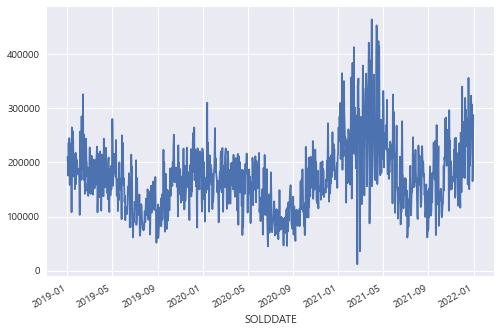

In [ ]:
df_timeseries.QUANT.plot()

### 정상성검정

In [ ]:
# 네~ ADF 검정을 통해 정상성이 아니라고 하네요.
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df_timeseries)

(0.022138563139749445, False)

### 훈련, 테스트 데이터 나눔

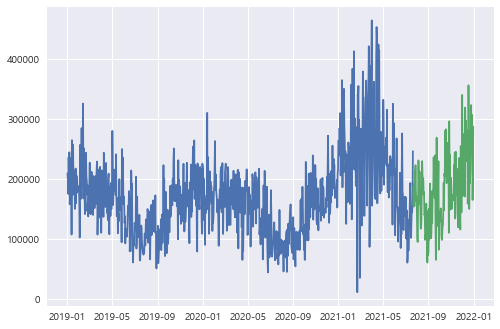

In [ ]:
cutoff = round(len(df_timeseries)*0.85)
train = df_timeseries[:cutoff]
test = df_timeseries[cutoff:]
plt.plot(train)
plt.plot(test)

### 실제 훈련

In [ ]:
from pmdarima.arima import auto_arima
# model = auto_arima(train, d=1, seasonal=True,random_state=0)
model = auto_arima(train, start_p = 0, start_q = 0, max_p = 5, max_d = 2, max_q = 5, start_P = 0, start_Q = 0,
                    max_P = 5, max_D = 2, max_Q = 5, trace=True, stepwise = True, m=12, seasonal=True,random_state=0, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=22888.928, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=22701.690, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=22497.901, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=22886.929, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=22514.444, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=22495.727, Time=0.53 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=22496.013, Time=0.26 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=22497.719, Time=2.90 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=22497.716, Time=3.14 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=22497.451, Time=1.43 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=22496.217, Time=1.07 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=6.83 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=22856.019, Time=0.34 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=22474.285, Time=0.69 sec
 ARIMA(1,1,

In [ ]:
# AIC ㅈㄴ 높음. 또라이급. 그냥 바로 갖다 버려야 할것 같은 느낌이 마구 든다
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  925
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -11239.375
Date:                Thu, 21 Apr 2022   AIC                          22484.749
Time:                        11:49:52   BIC                          22499.236
Sample:                             0   HQIC                         22490.276
                                - 925                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7333      0.026    -28.724      0.000      -0.783      -0.683
ma.L2         -0.1516      0.027     -5.555      0.000      -0.205      -0.098
sigma2      2.204e+09   1.26e-12   1.76e+21      0.000     2.2e+09     2.2e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               323.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.81e+37. Standard errors may be unstable.
"""

### 실제 예측 및 시각화

In [ ]:
pred = pd.DataFrame(model.predict(n_periods=len(df_timeseries) - cutoff),index=test.index,columns=['pred'])
pred

,pred
SOLDDATE,
2021-07-22,167228.620220
2021-07-23,151789.382979
2021-07-24,151789.382979
2021-07-25,151789.382979
2021-07-26,151789.382979
...,...
2021-12-27,151789.382979
2021-12-28,151789.382979
2021-12-29,151789.382979


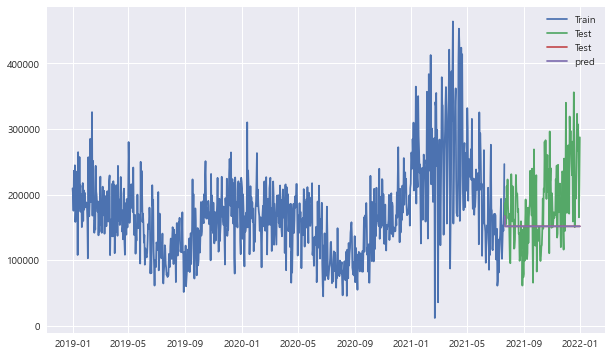

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(pred,label='pred')
plt.legend(loc='best')
plt.show()

In [ ]:
# 음수가 나오면 망설이지말고 폐기 하면 된다.
from sklearn.metrics import r2_score

def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

test['pred'] = pred

print(MAE(test.QUANT,test.pred))
print(MSE(test.QUANT,test.pred))
print(RMSE(test.QUANT,test.pred))
r2_score(test.QUANT,test.pred)

5.35e+04
4.69e+09
6.85e+04


C:\Users\chonh\AppData\Local\Temp\ipykernel_2172\977234624.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = pred


-0.34070672725590856

### 네~ 갖다 버리시면 되겠습니다!

- SARIMAX에서 일일히 계산해와서 보는 방식 자체는 같음.
- 함수가 자동으로 처리해주므로 편리하나, 기능은 같음
- 결론: 폐기 or 주단위나 한달단위까지 고려해봐야 함.
- 필자는 주단위로 해봤었는데 그래도 잘 안됨. 부실뻔
